In [4]:
import requests
import json

import numpy as np
import pandas as pd

from datetime import datetime
from dateutil.relativedelta import relativedelta
import pytz

from multiprocessing.pool import ThreadPool
from tqdm import tqdm_notebook as tqdm
from time import time as timer
from IPython.display import clear_output

%matplotlib inline

The distributionlayer of the waterwebservices from Rijkswaterstaat is minimal documented at <a href="https://www.rijkswaterstaat.nl/rws/opendata/DistributielaagWebservices-SUM-2v7.pdf">DistributielaagWebservices-SUM-2v7.pdf</a>. 

There are four different services with different type of request within each service. The servies are:
- MetadataServices
- OnlinewaarnemingenServices
- BulkwaarnemingServices
- WebFeatureServices

In this notebook are these services used to request the tide levels of the different gauge stations

In [5]:
OphalenCatalogus           = 'https://waterwebservices.rijkswaterstaat.nl/METADATASERVICES_DBO/OphalenCatalogus/'
OphalenWaarnemingen        = 'https://waterwebservices.rijkswaterstaat.nl/ONLINEWAARNEMINGENSERVICES_DBO/OphalenWaarnemingen'
OphalenLaatsteWaarnemingen = 'https://waterwebservices.rijkswaterstaat.nl/ONLINEWAARNEMINGENSERVICES_DBO/OphalenLaatsteWaarnemingen'

Start with a metadata request using the `OpenhalenCatalogus` service. In this request we want information on the units (eenheden), quantities (grootheden) and qualities (hoedanigheden).

In [6]:
# get station information from DDL (metadata uit Catalogus)
request = {
    "CatalogusFilter": {
        "Eenheden": True,
        "Grootheden": True,
        "Hoedanigheden": True
    }
}
resp = requests.post(OphalenCatalogus, json=request)
result = resp.json()
# print all variables in the catalogus
#print(result)

dfLocaties = pd.DataFrame(result['LocatieLijst']).set_index('Code')
# load normalized JSON object (since it contains nested JSON)
dfMetadata = pd.io.json.json_normalize(result['AquoMetadataLijst']).set_index('AquoMetadata_MessageID')

In [7]:
# note that there are two stations for IJmuiden. 
# The station was moved from the sluices to outside of the harbor in 1981.
ids = ['DELFZL', 'DENHDR', 'HARLGN', 'HOEKVHLD', 'IJMDBTHVN', 'IJMDNDSS', 'VLISSGN']
dfLocaties.loc[ids]

,Coordinatenstelsel,Locatie_MessageID,Naam,X,Y
Code,,,,,
DELFZL,25831,84020,Delfzijl,761899.770960,5.915790e+06
DENHDR,25831,84011,Den Helder,617198.393684,5.869731e+06
HARLGN,25831,84096,Harlingen,661021.585505,5.894519e+06
HOEKVHLD,25831,72345,Hoek van Holland,576917.669784,5.759136e+06
IJMDBTHVN,25831,84132,IJmuiden buitenhaven,605633.035699,5.813598e+06
IJMDNDSS,25831,84560,IJmuiden Noordersluis,609033.673551,5.814221e+06
VLISSGN,25831,84387,Vlissingen,541425.983215,5.699182e+06


Continue with requesting the observations using the `OpenhalenWaarnemingen` service

The waterwebservice make use of a POST query service based on JSON objects with the following 3 elemens defined:
- Locatie
- AquoPlusWaarnemingMetadata
- Periode

An example looks as follow:

In [8]:
request_manual = {
  'Locatie': {
    'X': 761899.770959577,
    'Y': 5915790.48491405,
    'Code': 'DELFZL'
  },
  'AquoPlusWaarnemingMetadata': {
    'AquoMetadata': {
      'Eenheid': {
        'Code': 'cm'
      },
      'Grootheid': {
        'Code': 'WATHTE'
      },
      'Hoedanigheid': {
        'Code': 'NAP'
      }
    }
  },
  'Periode': {
    'Einddatumtijd': '2012-01-27T09:30:00.000+01:00',
    'Begindatumtijd': '2012-01-27T09:00:00.000+01:00'
  }
}

In [9]:
eenhd = request_manual['AquoPlusWaarnemingMetadata']['AquoMetadata']['Eenheid']['Code']
grthd = request_manual['AquoPlusWaarnemingMetadata']['AquoMetadata']['Grootheid']['Code']
hdnghd = request_manual['AquoPlusWaarnemingMetadata']['AquoMetadata']['Hoedanigheid']['Code']
clmn = grthd+'_'+eenhd+hdnghd

This manual request can be send to the service. If successfull the service will return a JSON object that can be loaded into a pandas DataFrame and plotted in a figure

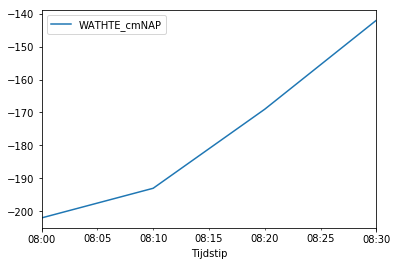

In [11]:
eenhd = request_manual['AquoPlusWaarnemingMetadata']['AquoMetadata']['Eenheid']['Code']
grthd = request_manual['AquoPlusWaarnemingMetadata']['AquoMetadata']['Grootheid']['Code']
hdnghd = request_manual['AquoPlusWaarnemingMetadata']['AquoMetadata']['Hoedanigheid']['Code']
clmn = grthd+'_'+eenhd+hdnghd

try:
    resp = requests.post(OphalenWaarnemingen, json=request_manual)
    df_out = pd.io.json.json_normalize(resp.json()['WaarnemingenLijst'][0]['MetingenLijst'])[['Meetwaarde.Waarde_Numeriek','Tijdstip']]
    df_out['Tijdstip'] = pd.to_datetime(df_out['Tijdstip'])
    df_out.set_index('Tijdstip', inplace=True)
    df_out.columns=[clmn]
    
    df_out.loc[df_out[clmn] == 999999999.0] = np.nan
    df_out.plot()
except Exception as e:
    print (e)

Next we dynamically create the POST request

In [12]:
def strftime(date):
    """
    required datetime format is not ISO standard date format.
    current conversion method works, but improvements are welcome
    asked on SO, but no responses: https://stackoverflow.com/q/45610753/2459096
    """
    (dt, micro,tz) = date.strftime('%Y-%m-%dT%H:%M:%S.%f%Z:00').replace('+','.').split('.')
    dt = "%s.%03d+%s" % (dt, int(micro) / 1000,tz)
    return dt

def POSTOphalenWaarnemingen(beginDatumTijd, dfLocatie, dfAquoMetadata):
    """
    create a JSOB object for a POST request for collection of observations
    
    Parameters
    ---
    beginDatumTijd   :  datetime object inc tzinfo 
                        (eindDatumTijd is hardcoded 1 month after beginDatumTijd)
    dfLocatie        :  dataframe met sinlge station location info
    dfAquoMetaData   :  dataframe object with single unit/quantity/quality information
    
    Return
    ------
    JSON object
    """
    # empty json object
    request_dynamisch = {}

    request_dynamisch['Locatie'] = {}
    rd_Locatie = request_dynamisch['Locatie']
    rd_Locatie['X'] = dfLocatie.X#float("{:.9f}".format(dfLocatie.loc[ids[0]].X))
    rd_Locatie['Y'] = dfLocatie.Y#float("{:.8f}".format(dfLocatie.loc[ids[0]].Y))
    rd_Locatie['Code'] = dfLocatie.name

    request_dynamisch['AquoPlusWaarnemingMetadata'] = {}
    rd_APWM = request_dynamisch['AquoPlusWaarnemingMetadata']
    rd_APWM['AquoMetadata'] = {}
    rd_AM = rd_APWM['AquoMetadata']
    rd_AM['Eenheid']      = {'Code':dfAquoMetadata['Eenheid.Code'].values[0]}
    rd_AM['Grootheid']    = {'Code':dfAquoMetadata['Grootheid.Code'].values[0]}
    rd_AM['Hoedanigheid'] = {'Code':dfAquoMetadata['Hoedanigheid.Code'].values[0]}

    request_dynamisch['Periode'] = {}
    rd_Periode = request_dynamisch['Periode']
    rd_Periode['Begindatumtijd'] = strftime(beginDatumTijd)
    #strftime(datetime(year=2012, month=1, day=27, hour=9, minute=0,tzinfo=pytz.timezone('Etc/GMT-1')))
    rd_Periode['Einddatumtijd']  = strftime(beginDatumTijd+relativedelta(months=1))
    
    return request_dynamisch

In [13]:
# create a long list of data objects
# only use start-dates since end-date is always 1 month after the start-date
startDates = []
for year in np.arange(1850,2018):
    for month in np.arange(1,13):
        startDates.append(datetime(year=year, month=month, day=1, hour=0, minute=0,tzinfo=pytz.timezone('Etc/GMT-1')))
startDates = pd.Series(startDates)
#startDates.head()

In [14]:
selDates = startDates[(startDates > '1879-01-01') & (startDates < '1879-06-01')]
selDates

349   1879-02-01 00:00:00+01:00
350   1879-03-01 00:00:00+01:00
351   1879-04-01 00:00:00+01:00
352   1879-05-01 00:00:00+01:00
353   1879-06-01 00:00:00+01:00
dtype: datetime64[ns, Etc/GMT-1]

In [15]:
# select a single station
for station in ids[0:1]:
    dfLocatie = dfLocaties.loc[station]
dfLocatie.head()

Coordinatenstelsel          25831
Locatie_MessageID           84020
Naam                     Delfzijl
X                          761900
Y                     5.91579e+06
Name: DELFZL, dtype: object

In [16]:
# select a metadata object using the unit/quanity/quality
df_WATHTE_NAP = dfMetadata[(dfMetadata['Grootheid.Code']=='WATHTE')&(dfMetadata['Hoedanigheid.Code']=='NAP')]
df_WATHTE_NAP.T.head()

AquoMetadata_MessageID,71
Eenheid.Code,cm
Eenheid.Omschrijving,centimeter
Grootheid.Code,WATHTE
Grootheid.Omschrijving,Waterhoogte
Hoedanigheid.Code,NAP


In [18]:
request_dynamic = POSTOphalenWaarnemingen(beginDatumTijd=selDates[3],dfLocatie=dfLocatie,dfAquoMetadata=df_WATHTE_NAP)
request_dynamic

{'AquoPlusWaarnemingMetadata': {'AquoMetadata': {'Eenheid': {'Code': 'cm'},
   'Grootheid': {'Code': 'WATHTE'},
   'Hoedanigheid': {'Code': 'NAP'}}},
 'Locatie': {'Code': 'DELFZL',
  'X': 761899.77095957706,
  'Y': 5915790.4849140504},
 'Periode': {'Begindatumtijd': '1879-05-01T00:00:00.000+01:00',
  'Einddatumtijd': '1879-06-01T00:00:00.000+01:00'}}

Open a HDFStore to retrieve month by month all observations and write to PyTables object.  

Create a function to fetch the data and write directly to disk.

In [20]:
def fetch_OphalenWaarnemingen(startDate,column_name):
    try:
        # prepare the POST object
        request_dynamisch=POSTOphalenWaarnemingen(beginDatumTijd = startDate,
                                                  dfLocatie = dfLocatie,
                                                  dfAquoMetadata = df_WATHTE_NAP)
        # do the query
        resp = requests.post(OphalenWaarnemingen, json=request_dynamisch)
        
        # parse the result to DataFrame
        df_out = pd.io.json.json_normalize(resp.json()['WaarnemingenLijst'][0]['MetingenLijst'])[['Meetwaarde.Waarde_Numeriek','Tijdstip']]
        df_out['Tijdstip'] = pd.to_datetime(df_out['Tijdstip'])
        df_out.set_index('Tijdstip', inplace=True)
        df_out.columns=[column_name]
        df_out.loc[df_out[column_name] == 999999999.0] = np.nan
        # add to HDFStore        
        hdf.append(key = dfLocatie.name+'/year'+str(startDate.year), 
                   value = df_out, format='table')
        
        return startDate, None
    except Exception as e:
        return startDate, e

iterate over the date range and locations and write to HDFStore as the information retrieved can become quite big.

### Warning, the execution of following codeblock takes multiple hours

In [21]:
hdf = pd.HDFStore('stationData.h5') # depends on PyTables
start = timer()

# itereer over stations
for station in tqdm(ids):
    dfLocatie = dfLocaties.loc[station]    

    for startDate in tqdm(startDates):
        startDate, error = fetch_OphalenWaarnemingen(startDate, column_name=clmn)

        if error is None:
            print("%r fetched and processed in %ss" % (startDate, timer() - start))
        else:
            print("error fetching %r: %s" % (startDate, error))
        clear_output(wait=True)
print("Elapsed time: %s" % (timer() - start,))    


Elapsed time: 10191.662999868393


In [ ]:
hdf.close()